<a href="https://colab.research.google.com/github/lorischl-otter/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [2]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


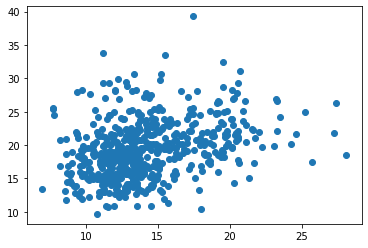

In [5]:
# Exploring data through a scatterplot
plt.scatter(df['radius_mean'], df['texture_mean']);

In [6]:
# Confirming all null values in final column
df['Unnamed: 32'].isnull

<bound method Series.isnull of 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
564   NaN
565   NaN
566   NaN
567   NaN
568   NaN
Name: Unnamed: 32, Length: 569, dtype: float64>

In [0]:
# Dropping null column
df = df.drop('Unnamed: 32', axis=1)


In [0]:
# Dropping ID column
df = df.drop('id', axis=1)

In [0]:
# Calculating the 'elbow method'
sum_of_squared_distances = []
K = range(1,15)
for k in K:
  km = KMeans(n_clusters=k)
  km = km.fit(df)
  sum_of_squared_distances.append(km.inertia_)

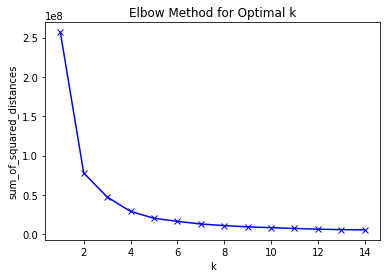

In [10]:
# Plotting the 'elbow method'
plt.plot (K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')
plt.show()


In [11]:
# KMeans calculation
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)
labels = kmeans.labels_

print(labels)

[1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 

In [12]:
# Adding KMeans labels to dv
kmeans = pd.Series(labels)
df['clusters'] = kmeans.values

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,clusters
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [18]:
supervised = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
supervised['diagnosis']

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [19]:
# Convert 'diagnosis' column into category numbers for plotting
supervised['diagnosis'] = supervised['diagnosis'].astype('category')

supervised['diagnosis']

# From this I can already see that I should have picked 2 categories instead of 
# 4 after my elbow plot ! Maybe I need to better understand how to make that
# selection

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: category
Categories (2, object): [B, M]

In [20]:
supervised['diagnosis'] = supervised['diagnosis'].cat.codes
supervised['diagnosis']

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int8

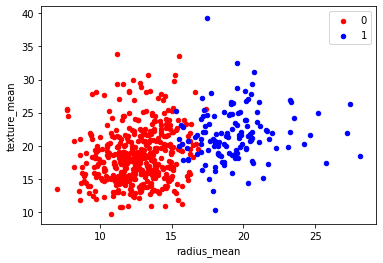

In [16]:
# Plot data from Clustering
fig, ax = plt.subplots()

colors = {0:'red', 1:'blue'}

grouped = df.groupby('clusters')
for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x='radius_mean', y='texture_mean',
             label=key, color=colors[key])
plt.show()

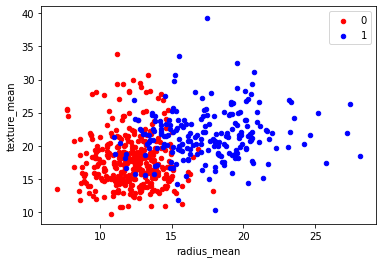

In [21]:
# Plot data from true data set
fig, ax = plt.subplots()

colors = {0:'red', 1:'blue'}

grouped = supervised.groupby('diagnosis')
for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x='radius_mean', y='texture_mean',
             label=key, color=colors[key])
plt.show()

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [38]:
# Remove 'clusters' column from dataframe to perform PCA

df_pca = df.drop('clusters', axis=1)
df_pca.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


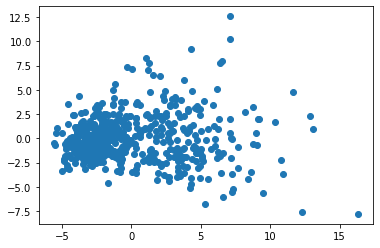

In [39]:
# Standardize Data 
scaler = StandardScaler()
Z = scaler.fit_transform(df_pca)

# Perform PCA
pca2 = PCA(2)
pca2.fit(Z)
B = pca2.transform(Z)

# Plot PCA

plt.scatter(B[:,0], B[:,1])
plt.show()

In [0]:
# Scree Plot
pca = PCA(6)
pca.fit(Z)
B = pca.transform(Z)
pca_features = pca.fit_transform(Z)

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

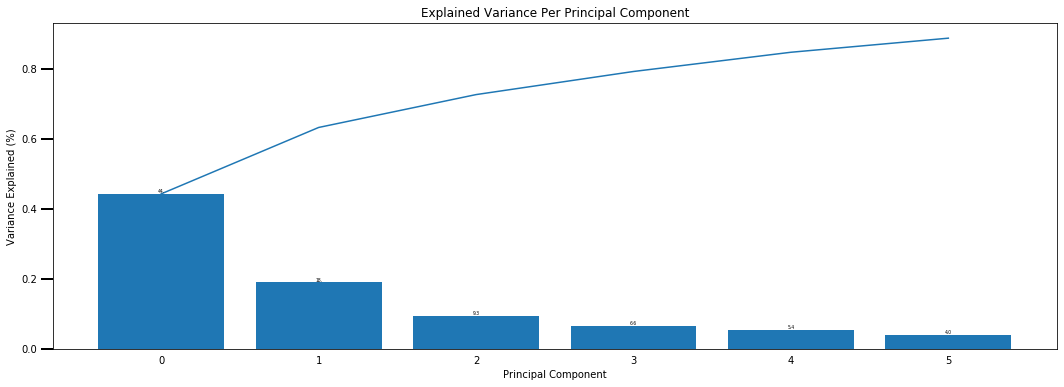

In [43]:
scree_plot(pca)

#  6 Principle Components will retain approximately 90% of the data

In [44]:
# Calculate KMeans with PCA data

kmeans = KMeans(2)
kmeans.fit(pca_features)

print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [46]:
# Add new cluster labels and diagnosis labels to dataframe
df_pca['clusters'] = kmeans.labels_
df_pca['diagnosis'] = supervised['diagnosis']

df_pca.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,clusters,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,1


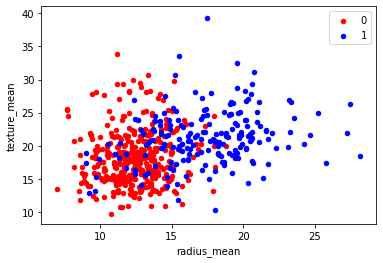

In [52]:
# Compare Scatterplots
fig, ax = plt.subplots()

colors = {0: 'red', 1: 'blue'}

grouped = df_pca.groupby('clusters')

for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x='radius_mean', y='texture_mean', label=key, color=colors[key])

plt.show()

# This graph looks much closer to the diagnosis scatter plot than the 
# original cluster scatterplot did 

In [51]:
# Calculating accuracy level
(df_pca['diagnosis'] == df_pca['clusters']).value_counts()[True] / df_pca.shape[0]

0.9050966608084359

In [48]:
pd.crosstab(df_pca['diagnosis'], df_pca['clusters'])

clusters,0,1
diagnosis,,
0,339,18
1,36,176


# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project